In [1]:
import cv2,os

data_path='dataset'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]


In [2]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 50x50, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here.

In [3]:
import numpy as np

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

In [10]:
np.save('data',data)
np.save('target',new_target)

In [11]:
import numpy as np

data=np.load('data.npy')
target=np.load('target.npy')

#loading the save numpy arrays in the previous code

In [4]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [5]:
data.shape[1:]

(100, 100, 1)

<h1>§2. Machine Learning Model</h1>

We will create a tf.keras.Sequential model using some of the layers we’ve discussed in class. We will include Conv2D layers, MaxPooling2D layers, Flatten layer, Dense layers, and Dropout layer in this model

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    # The first CNN layer, learn the base features, Convolution layer of a kernel size 200, 
    # shape 3*3 'relu' nonlinear transformation, also specify input shape
    layers.Conv2D(200,(3,3), activation='relu', input_shape=data.shape[1:]),
    # MaxPooling2D((2, 2)) 2*2 the size of window to find the max
    layers.MaxPooling2D((2, 2)),
    # layers.Dropout(0.5) force the model to not fit too closely, help relieve overfitting
    layers.Dropout(0.5),
    # The second convolution layer
    layers.Conv2D(100, (3, 3), activation='relu'),
    # MaxPooling layer
    layers.MaxPooling2D((2, 2)),
    # Flatten layer to stack the output convolutions from second convolution layer
    layers.Flatten(),
    # layers.Dropout(0.5) force the model to not fit too closely, help relieve overfitting
    layers.Dropout(0.5),
    #Dense layer of 50 neurons
    layers.Dense(50, activation='relu'),
    layers.Dense(2,activation='softmax') # 2: number of classes
])


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 200)       2000      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 200)       0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 100)       180100    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 100)       0         
_________________________________________________________________
flatten (Flatten)            (None, 52900)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 52900)             0

Now we will train model and plot the history of the accuracy on both the training and validation sets. 

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# from_logits=True compute softmax when evaluting loss function
# metrics=['accuracy'] want to see how accurate on the data
history = model.fit(train_data,
                     train_target, 
                     epochs=20, 
                     validation_split=0.2)

Epoch 1/20
32/32 [==============================] - 35s 1s/step - loss: 0.9982 - accuracy: 0.4723 - val_loss: 0.6914 - val_accuracy: 0.4739
Epoch 2/20
32/32 [==============================] - 32s 1s/step - loss: 0.6887 - accuracy: 0.5336 - val_loss: 0.6372 - val_accuracy: 0.6466
Epoch 3/20
32/32 [==============================] - 38s 1s/step - loss: 0.5997 - accuracy: 0.6615 - val_loss: 0.5419 - val_accuracy: 0.7028
Epoch 4/20
32/32 [==============================] - 41s 1s/step - loss: 0.4221 - accuracy: 0.8058 - val_loss: 0.2144 - val_accuracy: 0.9438
Epoch 5/20
32/32 [==============================] - 42s 1s/step - loss: 0.3531 - accuracy: 0.8542 - val_loss: 0.2210 - val_accuracy: 0.9398
Epoch 6/20
32/32 [==============================] - 42s 1s/step - loss: 0.2609 - accuracy: 0.9060 - val_loss: 0.1793 - val_accuracy: 0.9679
Epoch 7/20
32/32 [==============================] - 44s 1s/step - loss: 0.2150 - accuracy: 0.9113 - val_loss: 0.1661 - val_accuracy: 0.9558
Epoch 8/20
32/32 [==

We want to visualize the training history.

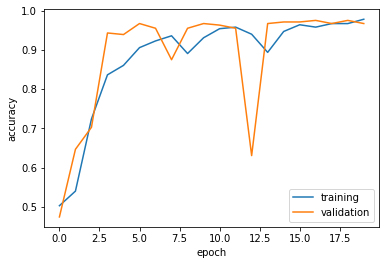

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy") # gca: get current axis 
plt.legend()

Now we would want to evaluate the accuracy of the model on the test dataset

In [19]:
print(model.evaluate(test_data,test_target))

5/5 [==============================] - 1s 197ms/step - loss: 0.1824 - accuracy: 0.9420
[0.18243618309497833, 0.9420289993286133]


In [15]:
model.save('mask.model',overwrite=True,include_optimizer=True,save_format=None,signatures=None,options=None)

INFO:tensorflow:Assets written to: mask.model\assets


In [17]:
model = models.load_model('mask.model')